In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
adityajn105_flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')

print('Data source import complete.')


Data source import complete.


# Importing

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,TimeDistributed, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import re

# Read Data

## Captions

In [ ]:
image_path = '/kaggle/input/flickr8k/Images'
df = pd.read_csv('/kaggle/input/flickr8k/captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"{image_path}/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

## Display Images

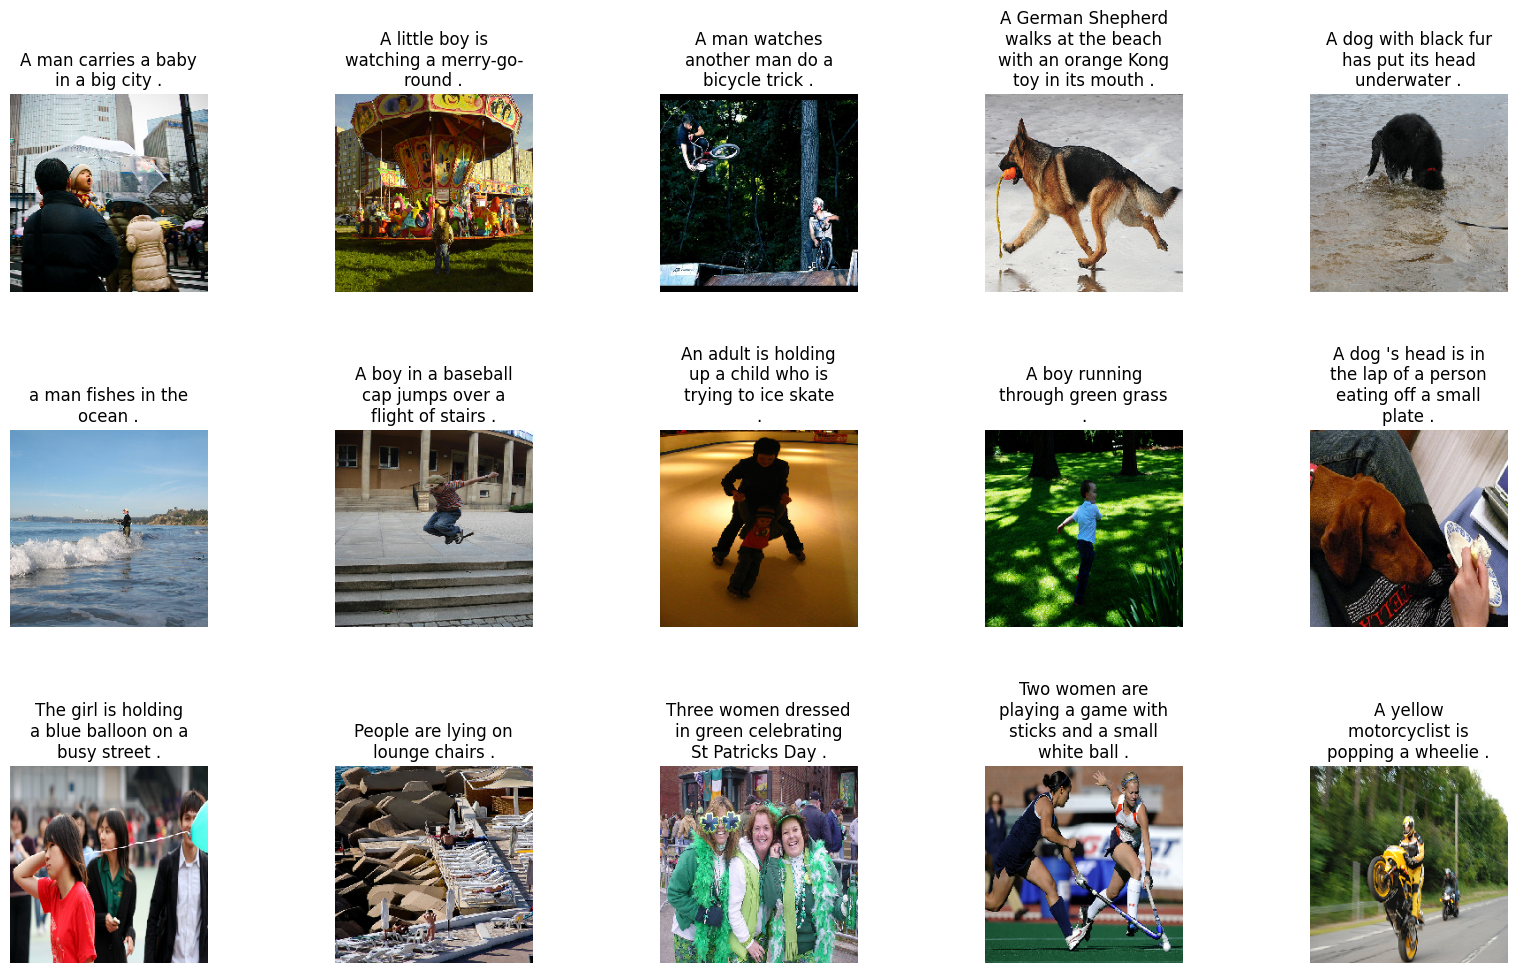

In [ ]:
display_images(df.sample(15))

# Preprocessing

## Caption Text Preprocessong

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    data['caption'] = data['caption'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1 or word in ['a', 'i']]))
    data['caption'] = data['caption'].apply(lambda x: 'startseq ' + x + ' endseq')

    return data

In [ ]:
df = text_preprocessing(df)
captions = df['caption'].tolist()
captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tricolored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Tokenization and Encoded

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

unique_images = df['image'].unique()
# split image names
train_images, val_images = train_test_split(unique_images, test_size=0.15, random_state=42)

train = df[df['image'].isin(train_images)].reset_index(drop=True)
test = df[df['image'].isin(val_images)].reset_index(drop=True)

# tokenize one caption
tokenizer.texts_to_sequences([captions[1]])[0]

[2, 1, 19, 313, 64, 1, 193, 117, 3]

# Image Feature Extraction

## Using CNN Pretrained Model

In [ ]:
model = EfficientNetB7(weights='imagenet', include_top=False, pooling='avg')

img_size = 600
features = {}

# Loop through each unique image
for image in tqdm(df['image'].unique().tolist()):
    # Load and preprocess the image
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = preprocess_input(img)  # Use EfficientNet's preprocessing
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Extract features using the model directly
    feature = model.predict(img, verbose=0)
    features[image] = feature[0]

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


100%|██████████| 8091/8091 [23:23<00:00,  5.76it/s]


## EfficientNetB7 Representation
![Architecture-of-EfficientNetB7-with-MBConv-as-basic-building-blocks-The-overall.png](attachment:Architecture-of-EfficientNetB7-with-MBConv-as-basic-building-blocks-The-overall.png)

- EfficientNetB7 process image though all convolution blocks and at the end applies Global Average Pooling , and output shape (1, 2560) → meaning 2560 features extracted from the image.

# LSTM Modeling

### Images and Text

In [ ]:
input1 = Input(shape=(2560,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
caption_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2560)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    655,616 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 37, 256)   │  2,245,120 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8770)      │  1,131,330 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,590,274 (17.51 MB)

 Trainable params: 4,590,274 (17.51 MB)

 Non-trainable params: 0 (0.00 B)

# Data Generation

→ Data Generation is a way to efficiently prepare and load batches of training data while the model is training, without killing your RAM.

In [ ]:
class CaptionDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [ ]:
train_generator = CaptionDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CaptionDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
caption_model.save('model.h5')

In [ ]:
caption_model.save('model.keras')

In [ ]:
model_name = "/kaggle/working/emotion_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Model Training

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 3.6428
Epoch 1: val_loss improved from inf to 3.41237, saving model to /kaggle/working/emotion_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 111s 206ms/step - loss: 3.6427 - val_loss: 3.4124 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 3.4429
Epoch 2: val_loss improved from 3.41237 to 3.33653, saving model to /kaggle/working/emotion_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 107s 199ms/step - loss: 3.4429 - val_loss: 3.3365 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 3.3217
Epoch 3: val_loss improved from 3.33653 to 3.29144, saving model to /kaggle/working/emotion_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 108s 201ms/step - loss: 3.3217 - val_loss: 3.2914 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 3.2313
Epoch 4: val_loss improved from 3.29144 to 3.25370, saving model to /kaggle/working/emotion_model.keras
537

- It's important to note that accuracy is not a very meaningful metric for image captioning tasks, since the model generates a sequence of words and a single incorrect word can mark the whole prediction as "wrong."

- Instead, the loss (categorical crossentropy) is a more reliable indicator of performance during training and validation, as it reflects how well the predicted word distributions match the ground truth.

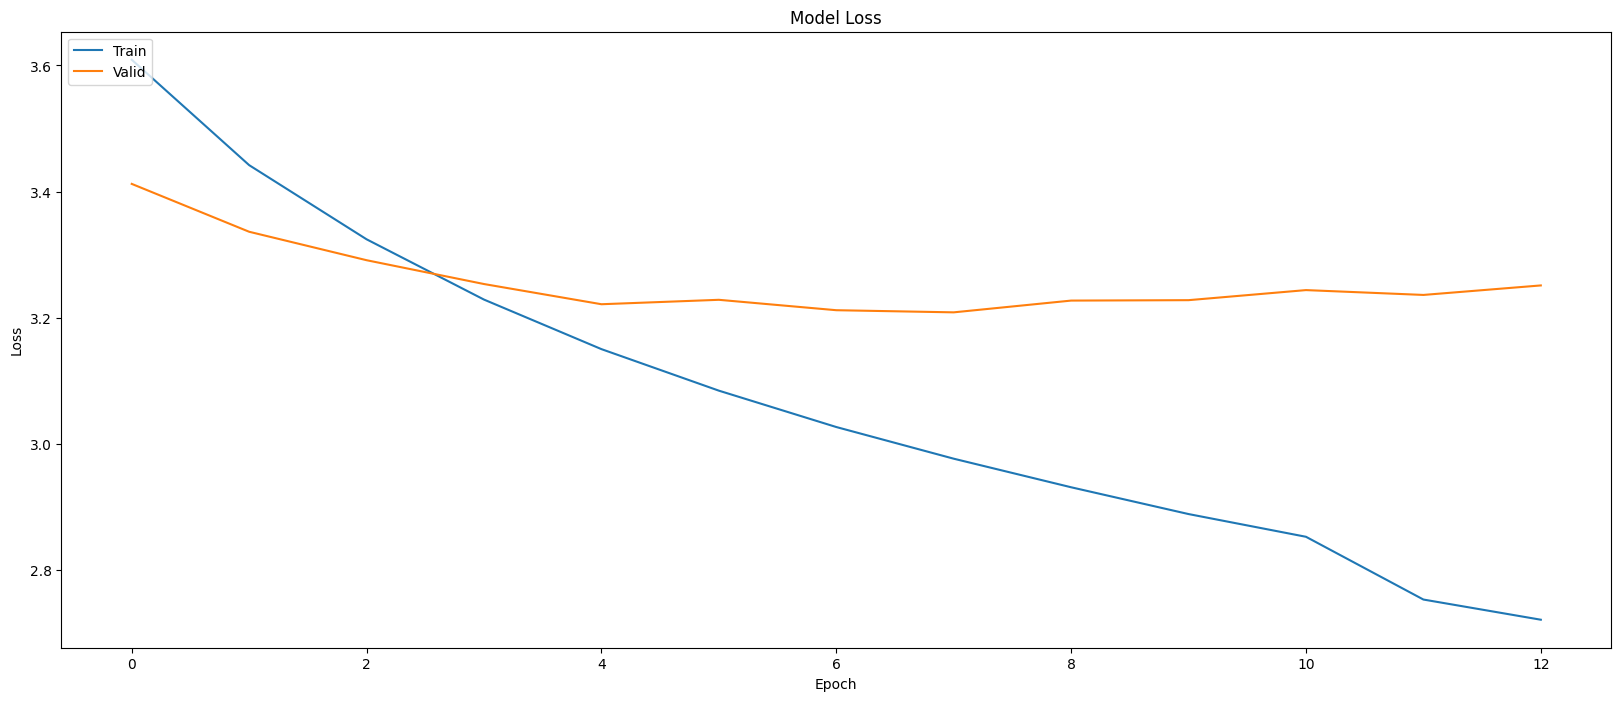

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Testing the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


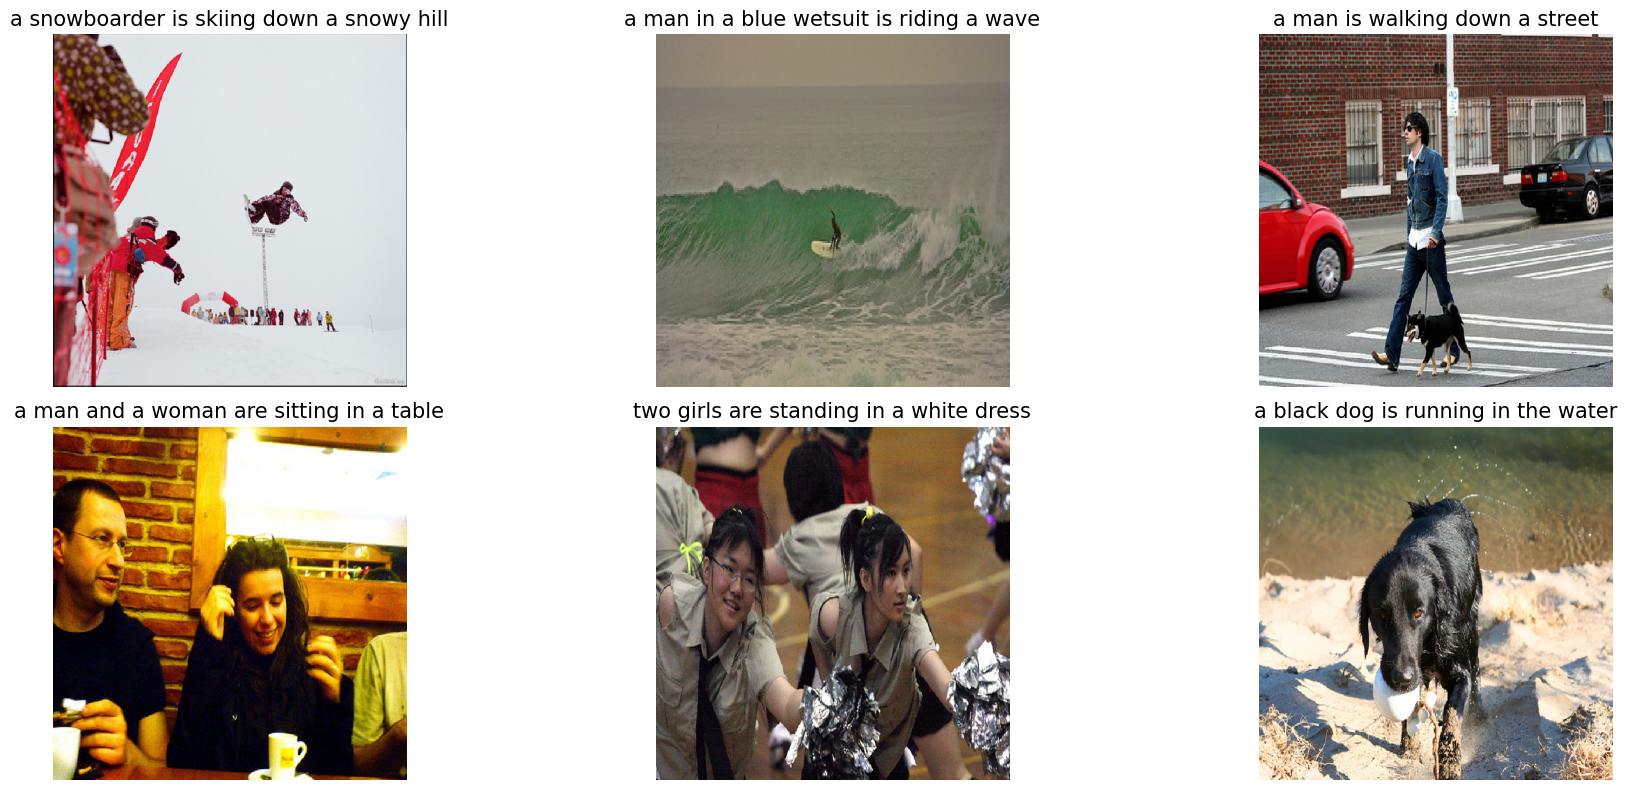

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_caption(model, tokenizer, photo_feature, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo_feature.reshape((1, 2560)), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = next((w for w, idx in tokenizer.word_index.items() if idx == yhat), None)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return ' '.join(in_text.split()[1:])  # Remove 'startseq'

# Image directory
image_folder = '/kaggle/input/flickr8k/Images'
all_images = os.listdir(image_folder)
selected_images = all_images[10:16]

# Plot settings
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
axes = axes.flatten()

for i, image_name in enumerate(selected_images):
    img_path = os.path.join(image_folder, image_name)

    # Preprocess image
    img = load_img(img_path, target_size=(600, 600))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Feature extraction
    feature = model.predict(img_array)[0]

    # Generate caption
    caption = generate_caption(caption_model, tokenizer, feature, max_length)

    # Display on subplot
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(caption, fontsize=15)

plt.tight_layout()
plt.show()